# AutoEncoders

> Collection of Autoencoder models

In [ ]:
#| default_exp models.autoencoders

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

In [ ]:
#| export

import torch.nn as nn
import torch
from torch.utils.data import DataLoader
from lightning import LightningModule, Trainer
from lightning.pytorch.loggers import CSVLogger, TensorBoardLogger
from lightning.pytorch.tuner.tuning import Tuner
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint

from hydra.utils import instantiate
from omegaconf import OmegaConf
from pprint import pprint

from matplotlib import pyplot as plt
import pandas as pd

from nimrod.image.datasets import ImageDataset
from nimrod.models.conv import ConvLayer, DeconvLayer
from nimrod.utils import time_it, set_seed, get_device

import logging
import warnings

Seed set to 42
/user/s/slegroux/miniconda3/envs/nimrod/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
Seed set to 42


ImportError: cannot import name 'ConvLayer' from 'nimrod.models.conv' (/user/s/slegroux/Projects/nimrod/nimrod/models/conv.py)

In [ ]:
#| export
set_seed(42)
logger = logging.getLogger(__name__)
# logger.setLevel(logging.DEBUG)
plt.set_loglevel('INFO')
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

Seed set to 42


## Fashion MNIST

In [ ]:
#| notest
cfg = OmegaConf.load('../config/data/image/image.yaml')
dm = instantiate(cfg, name='fashion_mnist', data_dir='../data/image/')
dm.prepare_data()
dm.setup()
print(dm.num_classes)

[15:41:01] INFO - Init ImageDataModule for fashion_mnist


HfHubHTTPError: 504 Server Error: Gateway Time-out for url: https://huggingface.co/api/datasets/zalando-datasets/fashion_mnist/paths-info/531be5e2ccc9dba0c201ad3ae567a4f3d16ecdd2

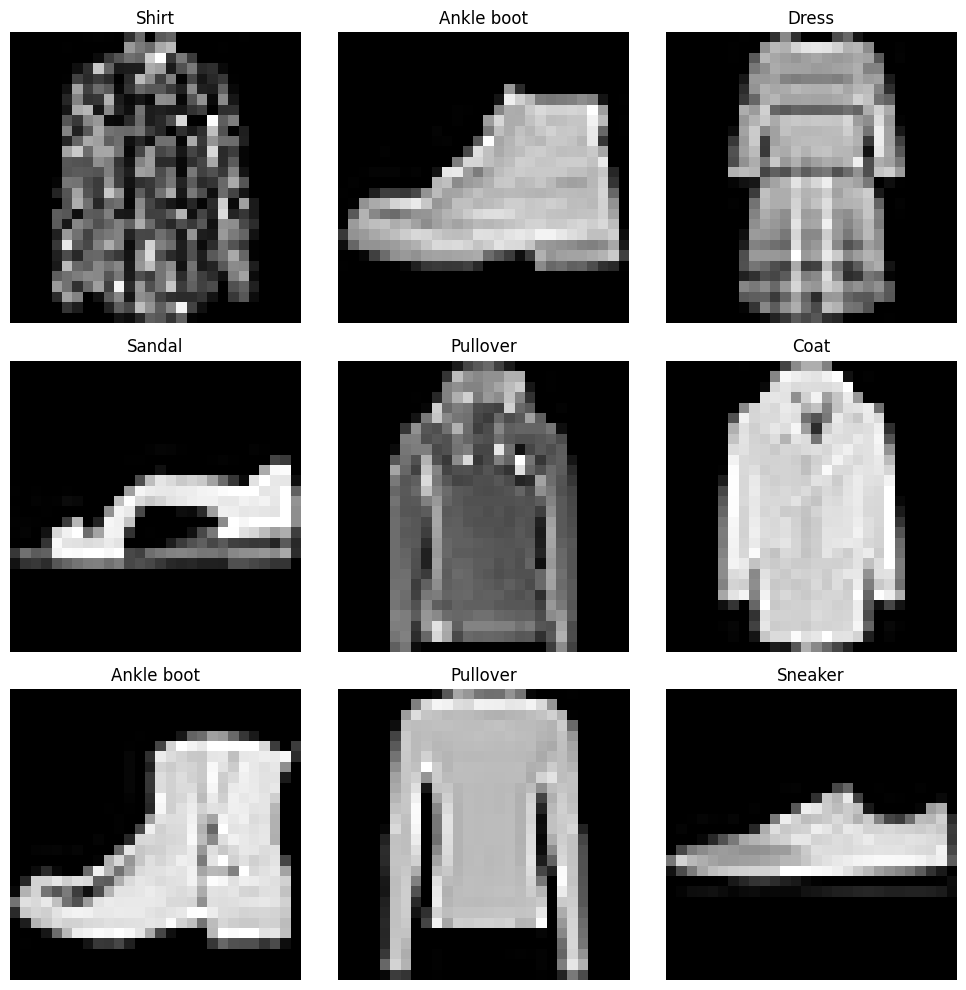

In [ ]:
#| notest
dm.show_grid(3,3)

In [ ]:
#| notest
print(dm.label_names)

RuntimeError: train_ds is not initialized. Call prepare_data() first.

### ConvNet

In [ ]:
cfg = OmegaConf.load('../config/model/image/convnetx_adam.yaml')
# nnet = instantiate(cfg.nnet, num_classes=dm.num_classes)
# optimizer = instantiate(cfg.optimizer)
# scheduler = instantiate(cfg.scheduler)

# model = ConvNetX(nnet, dm.num_classes, optimizer, scheduler)
model = instantiate(cfg, num_classes=10)

[15:41:17] INFO - ConvNetX: init
[15:41:17] INFO - Classifier: init


In [ ]:
#| notest
MAX_EPOCHS = 5
dm.batch_size = 256
print(dm.batch_size)
# lr = 0.4

trainer = Trainer(
    max_epochs=MAX_EPOCHS,
    logger=CSVLogger("logs", name="fashion_mnist_convnet"),
    callbacks = [LearningRateMonitor(logging_interval="step")],
    check_val_every_n_epoch=1,
    log_every_n_steps=1
    )


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


256


### LR Finder

In [ ]:
#| notest
tuner = Tuner(trainer)
lr_finder = tuner.lr_find(
    model,
    datamodule=dm,
    min_lr=1e-6,
    max_lr=1.0,
    num_training=100,  # number of iterations
    # attr_name="optimizer.lr",
)
fig = lr_finder.plot(suggest=True)
plt.show()
print(f"Suggested learning rate: {lr_finder.suggestion()}")

You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
[22:43:36] INFO - loading dataset fashion_mnist with args () from split train
[22:43:36] INFO - loading dataset fashion_mnist from split train
Overwrite dataset info from restored data version if exists.
[22:43:37] INFO - Overwrite dataset info from restored data version if exists.
Loading Dataset info from ../data/image/fashion_mnist/fashion_mnist/0.0.0/531be5e2ccc9dba0c201ad3ae567a4f3d16ecdd2
[22:43:37] INFO - Loading Dataset info from ../data/image/fashion_mnist/fashion_mnist/0.0.0/531be5e2ccc9dba0c201ad3ae567a4f3d16ecdd2
Found cached dataset fashion_mnist (/user/s/slegroux/Projects/nimrod/nbs/../data/image/fashion_mnist/fash

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

RuntimeError: Detected more unique values in `preds` than expected. Expected only 10 but found 30 in `preds`. Found values: tensor([ 0,  1,  3,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 19, 20, 21, 22,
        23, 25, 27, 28, 29, 30, 31, 32, 33, 34, 38, 39], device='cuda:0').

In [ ]:
# print(f"lr: {model.lr}, bs: {dm.batch_size}")

lr: 9.120108393559098e-06, bs: 256


### Fit

In [ ]:
#| notest

cfg.optimizer.lr = 0.4
print(OmegaConf.to_yaml(cfg))

model = instantiate(cfg)
trainer.fit(model, dm.train_dataloader(), dm.val_dataloader())


[22:10:36] INFO - ConvNetX: init
[22:10:36] INFO - Classifier: init


_target_: nimrod.models.conv.ConvNetX
num_classes: 10
nnet:
  _target_: nimrod.models.conv.ConvNet
  n_features:
  - 1
  - 8
  - 16
  - 32
  - 64
  num_classes: ${..num_classes}
  kernel_size: 3
  bias: null
  normalization:
    _target_: hydra.utils.get_class
    path: torch.nn.BatchNorm2d
  activation:
    _target_: hydra.utils.get_class
    path: torch.nn.ReLU
optimizer:
  _target_: torch.optim.Adam
  _partial_: true
  lr: 0.4
scheduler:
  _target_: torch.optim.lr_scheduler.ReduceLROnPlateau
  _partial_: true
  mode: min
  factor: 0.1
  patience: 5



/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'nnet' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['nnet'])`.
[22:10:54] INFO - Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.4
    maximize: False
    weight_decay: 0
)
[22:10:54] INFO - Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object>

  | Name         | Type               | Params | Mode 
------------------------------------------------------------
0 | loss         | CrossEntropyLoss   | 0      | train
1 | train_acc    | MulticlassAccuracy | 0      | train
2 | val_acc      | MulticlassAccuracy | 0      | train
3 | test_acc     | MulticlassAccuracy | 0      | train
4 | train_loss   | MeanMetric         | 0      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[22:11:24] INFO - scheduler is an instance of Reduce plateau


Validation: |          | 0/? [00:00<?, ?it/s]

[22:11:54] INFO - scheduler is an instance of Reduce plateau


Validation: |          | 0/? [00:00<?, ?it/s]

[22:12:24] INFO - scheduler is an instance of Reduce plateau


Validation: |          | 0/? [00:00<?, ?it/s]

[22:12:55] INFO - scheduler is an instance of Reduce plateau


Validation: |          | 0/? [00:00<?, ?it/s]

[22:13:25] INFO - scheduler is an instance of Reduce plateau
`Trainer.fit` stopped: `max_epochs=5` reached.


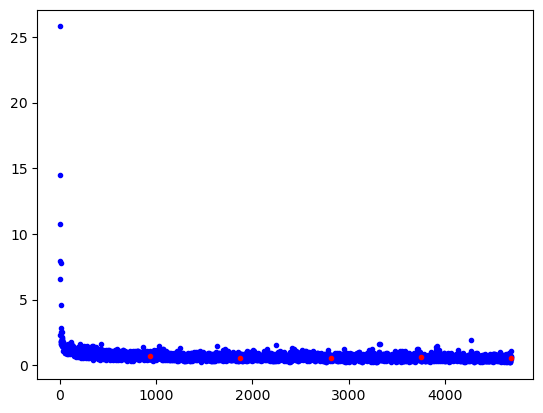

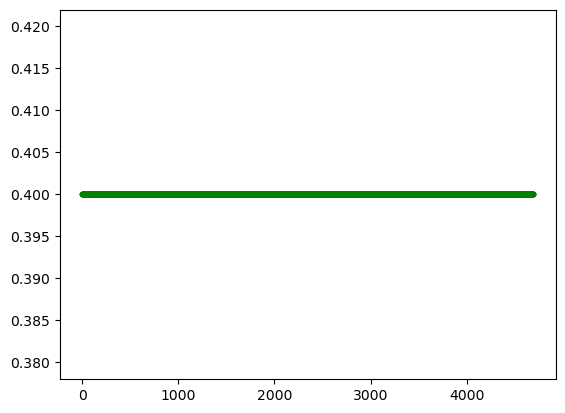

In [ ]:
#| notest



########################
csv_path = f"{trainer.logger.log_dir}/metrics.csv"
metrics = pd.read_csv(csv_path)
metrics.head()

#########################
plt.figure()
plt.plot(metrics['step'], metrics['train/loss_step'], 'b.-')
plt.plot(metrics['step'], metrics['val/loss'],'r.-')
plt.figure()
plt.plot(metrics['step'], metrics['lr-Adam'], 'g.-')
plt.show()

In [ ]:
#| notest
trainer.test(model, dm.test_dataloader())

/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │     0.803600013256073     │
│         test/loss         │    0.5951264500617981     │
└───────────────────────────┴───────────────────────────┘

[{'test/loss': 0.5951264500617981, 'test/acc': 0.803600013256073}]

## FC Autoencoder 

In [ ]:
#| export
class AutoEncoder(nn.Module):
    """ A modular autoencoder with configurable encoder and decoder """
    def __init__(self,
        encoder:nn.Module, # Encoder layer
        decoder:nn.Module # Decoder layer
        ):

        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(
        self,
        x:torch.Tensor # Tensor B x C X H X W
        )->torch.Tensor: # Reconstructed input tensor of shape B x C X H X W

        """
        Forward pass of the AutoEncoder model.
        """

        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

In [ ]:
class LinearEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Sequential(nn.Linear(28 * 28, 64), nn.ReLU(), nn.Linear(64, 3))

    def forward(self, x):
        return self.l1(x)


class LinearDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Sequential(nn.Linear(3, 64), nn.ReLU(), nn.Linear(64, 28 * 28))

    def forward(self, x):
        return self.l1(x)

In [ ]:
enc = LinearEncoder()
dec = LinearDecoder()
a = AutoEncoder(enc, dec)
batch = torch.rand((5, 3, 28*28))
encoded = enc(batch)
print(encoded.shape)
# y = a(batch)
# print(y.shape)

torch.Size([5, 3, 3])


In [ ]:
#| notest
ds = ImageDataset(name='fashion_mnist', data_dir='../data/image/')
dl = DataLoader(ds, batch_size=3)
b = next(iter(dl))
print(f" X: {b[0].shape}, Y: {b[1].shape}")


 X: torch.Size([3, 1, 28, 28]), Y: torch.Size([3])


In [ ]:
#| notest

acfg = OmegaConf.load('../config/data/image/image.yaml')
dm = instantiate(cfg, name='fashion_mnist', data_dir='../data/image/')
dm.prepare_data()
dm.setup()
# print(f"num classes: {dm.num_classes}, bs: {dm.batch_size}, labels: {dm.label_names}" if dm.label_names else f"num classes: {dm.num_classes}")

[14:58:07] INFO - Init ImageDataModule for fashion_mnist
[14:58:22] INFO - split train into train/val [0.8, 0.2]
[14:58:22] INFO - train: 48000 val: 12000, test: 10000


In [ ]:
#| notest

device = get_device()
print(f"Device: {device}")
enc = LinearEncoder()
dec =LinearDecoder()
model = AutoEncoder(enc, dec).to(device)

[14:55:26] INFO - Using device: mps


Device: mps


In [ ]:
#| notest

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


N_EPOCHS = 5

for epoch in range(N_EPOCHS):
    i = 0
    model.train()
    for images, labels in dm.train_dataloader():
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)
        # B x C x H x W -> B x C x L
        images = images.view(-1, images.size(2) * images.size(3))
        outputs = model(images)
        # output should be as close to input as possible
        loss = criterion(outputs, images)        
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        total_loss, epoch_step = 0, 0
        for images, labels in dm.val_dataloader():
            images, labels = images.to(device), labels.to(device)
            images = images.view(-1, images.size(2) * images.size(3))
            outputs = model(images)
            eval_loss = criterion(outputs, images)
            epoch_len = len(images)
            epoch_step += epoch_len
            total_loss += eval_loss.item() * epoch_len
    logger.info(f"Epoch: {epoch}, len: {epoch_len}, Loss: {total_loss / epoch_step:.3f}")



[14:56:24] INFO - Epoch: 0, len: 32, Loss: 0.025
[14:56:27] INFO - Epoch: 1, len: 32, Loss: 0.025
[14:56:31] INFO - Epoch: 2, len: 32, Loss: 0.025
[14:56:35] INFO - Epoch: 3, len: 32, Loss: 0.025
[14:56:39] INFO - Epoch: 4, len: 32, Loss: 0.025


 X: torch.Size([64, 1, 28, 28]), Y: torch.Size([64])
 X_hat: torch.Size([64, 1, 28, 28])


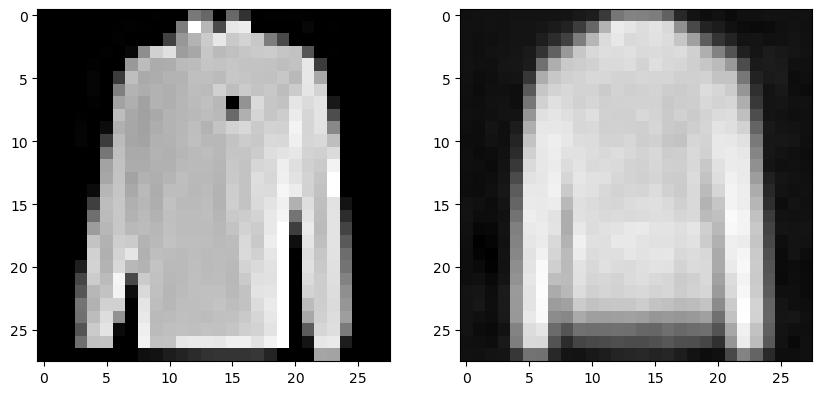

In [ ]:
#| notest
x, y = next(iter(dm.train_dataloader()))
print(f" X: {x.shape}, Y: {y.shape}")
x = x.to(device)
B, C, H, W = x.shape
x_hat = model(x.view(-1, H * W)).view(-1, C, H, W)
print(f" X_hat: {x_hat.shape}")
idx = 0
n_rows, n_cols = 1, 2
fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 10))
axs[0].imshow(x[idx].permute(1, 2, 0).cpu().numpy(), cmap='gray')
axs[1].imshow(x_hat[idx].permute(1, 2, 0).detach().cpu().numpy(), cmap='gray')
plt.show()


## ConvNet Autoencoder

In [ ]:
class ConvEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        layers = nn.ModuleList()
        # X -> B,C,28,28
        layers.append(nn.ZeroPad2d(2)) # X -> B,C,32,32
        layers.append(ConvLayer(1,2, normalization=None)) # 16 x 16
        layers.append(ConvLayer(2,4, normalization=None)) # 8 x 8
        self._nnet = nn.Sequential(*layers)

    def forward(self, x:torch.Tensor)->torch.Tensor:
        return self._nnet(x)

In [ ]:
class ConvDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        layers = nn.ModuleList()
        layers.append(DeconvLayer(4,2, normalization=None)) # 16 x 16
        layers.append(DeconvLayer(2,1, normalization=None, activation=None)) # 32 x 32
        layers.append(nn.ZeroPad2d(-2)) # 28 x 28
        layers.append(nn.Sigmoid())
        self._nnet = nn.Sequential(*layers)

    def forward(self, x:torch.Tensor)->torch.Tensor:
        return self._nnet(x)

In [ ]:
#| notest
device = get_device()
print(f"Device: {device}")
enc = ConvEncoder()
dec = ConvDecoder()
model = AutoEncoder(enc, dec).to(device)

[22:44:23] INFO - Using device: cuda


Device: cuda


In [ ]:
#| notest

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


N_EPOCHS = 5

for epoch in range(N_EPOCHS):
    i = 0
    model.train()
    for images, labels in dm.train_dataloader():
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)

        # images = images.view(-1, images.size(2) * images.size(3))
        outputs = model(images)
        # output should be as close to input as possible
        loss = criterion(outputs, images)        
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        total_loss, epoch_step = 0, 0
        for images, labels in dm.val_dataloader():
            images, labels = images.to(device), labels.to(device)
            # images = images.view(-1, images.size(2) * images.size(3))
            outputs = model(images)
            eval_loss = criterion(outputs, images)
            epoch_len = len(images)
            epoch_step += epoch_len
            total_loss += eval_loss.item() * epoch_len
    logger.info(f"Epoch: {epoch}, len: {epoch_len}, Loss: {total_loss / epoch_step:.3f}")

[15:34:38] INFO - Epoch: 0, len: 32, Loss: 0.012
[15:34:43] INFO - Epoch: 1, len: 32, Loss: 0.011
[15:34:48] INFO - Epoch: 2, len: 32, Loss: 0.011
[15:34:53] INFO - Epoch: 3, len: 32, Loss: 0.011
[15:34:59] INFO - Epoch: 4, len: 32, Loss: 0.011


 X: torch.Size([64, 1, 28, 28]), Y: torch.Size([64])
 X_hat: torch.Size([64, 1, 28, 28])


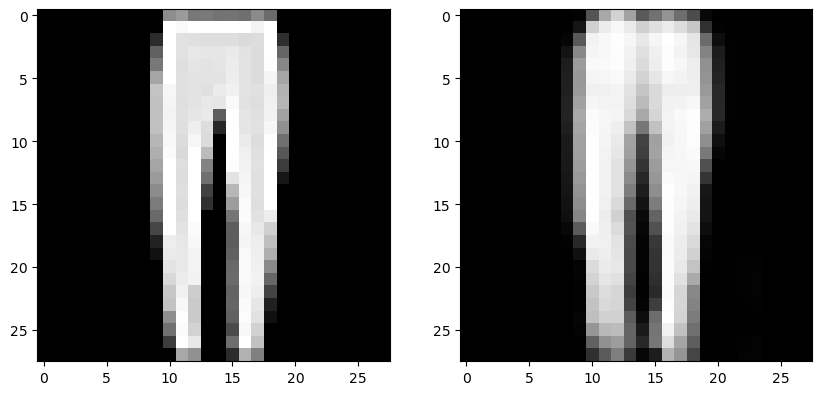

In [ ]:
#| notest
x, y = next(iter(dm.train_dataloader()))
print(f" X: {x.shape}, Y: {y.shape}")
x = x.to(device)
B, C, H, W = x.shape
x_hat = model(x)
print(f" X_hat: {x_hat.shape}")
idx = 0
n_rows, n_cols = 1, 2
fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 10))
axs[0].imshow(x[idx].permute(1, 2, 0).cpu().numpy(), cmap='gray')
axs[1].imshow(x_hat[idx].permute(1, 2, 0).detach().cpu().numpy(), cmap='gray')
plt.show()


## AutoEncoder_X

In [ ]:
#| hide notest
class AutoEncoderPL(LightningModule):
    """ LightningModule for AutoEncoder """
    def __init__(
        self,
        autoencoder:AutoEncoder # AutoEncoder instance
        ):
        super().__init__()
        # self.save_hyperparameters()
        self.save_hyperparameters(ignore=['autoencoder'])
        self.autoencoder = autoencoder
        self.metric = torch.nn.MSELoss()

    def forward(
        self,
        x: torch.Tensor # Tensor B x L
        )->torch.Tensor: # Reconstructed input tensor of shape B x L
        """
        Forward pass of the AutoEncoder model.
        """
        return self.autoencoder(x)
    
    def predict_step(self, batch, batch_idx):
        """
        Forward pass of the AutoEncoder model.
        """
        x, y = batch
        x = x.view(x.size(0), -1)
        with torch.no_grad():
            return self.autoencoder(x)

    def _shared_eval(self, batch, batch_idx, prefix, prog_bar=True, on_step=False, on_epoch=True, sync_dist=True):
        x, _ = batch
        x = x.view(x.size(0), -1) # flatten B x C x H x W to B x L (grey pic)
        x_hat = self.autoencoder(x)
        loss = self.metric(x_hat, x)
        self.log(f"{prefix}/loss", loss, on_step=on_step, on_epoch=on_epoch, sync_dist=sync_dist)
        return loss

    def training_step(self, batch, batch_idx):
        return self._shared_eval(batch, batch_idx, "train")
    
    def test_step(self, batch, batch_idx):
        self._shared_eval(batch, batch_idx, "test")
    
    def validation_step(self, batch, batch_idx):
        return self._shared_eval(batch, batch_idx, "val")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


In [ ]:
#show_doc(AutoEncoderPL.forward)

---

### AutoEncoderPL.forward

>      AutoEncoderPL.forward (x:torch.Tensor)

*Forward pass of the AutoEncoder model.*

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| x | Tensor | Tensor B x L |
| **Returns** | **Tensor** | **Reconstructed input tensor of shape B x L** |

In [ ]:
#| hide
# def on_validation_batch_end(
#         self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx, wadn
#         ):
#         # `outputs` comes from `LightningModule.validation_step`
#         # which corresponds to our model predictions in this case
        
#         # Let's log 20 sample image predictions from the first batch
#         if batch_idx == 0:
#             n = 20
#             x, y = batch
#             images = [img for img in x[:n]]
#             captions = [f'Ground Truth: {y_i} - Prediction: {y_pred}' 
#                 for y_i, y_pred in zip(y[:n], outputs[:n])]
            
            
#             # Option 1: log images with `WandbLogger.log_image`
#             wandb_logger.log_image(
#                 key='sample_images', 
#                 images=images, 
#                 caption=captions)


In [ ]:
#| notest hide
autoencoder_pl = AutoEncoderPL(a)
b = torch.rand((5,28*28))
y = autoencoder_pl(b)
print(y.shape)

torch.Size([5, 784])


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()